<a href="https://colab.research.google.com/github/Leorasaharia/walmart_backend/blob/main/walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving features.csv.zip to features.csv.zip
Saving sampleSubmission.csv.zip to sampleSubmission.csv.zip
Saving stores.csv to stores.csv
Saving test.csv.zip to test.csv.zip
Saving train.csv.zip to train.csv.zip


In [ ]:
import zipfile

# List of your ZIP files
zip_files = [
    'train.csv.zip',
    'features.csv.zip',
    'test.csv.zip',
    'sampleSubmission.csv.zip'
]

for zf in zip_files:
    with zipfile.ZipFile(zf, 'r') as zip_ref:
        zip_ref.extractall()


In [ ]:
import pandas as pd

train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')  # This file was already a CSV
test = pd.read_csv('test.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/walmart/'


In [ ]:
import os
print(os.listdir(folder_path))


['features.csv.zip', 'test.csv.zip', 'sampleSubmission.csv.zip', 'train.csv.zip', 'stores.csv']


In [ ]:
import zipfile
import os

folder_path = '/content/drive/MyDrive/walmart'
zip_files = [f for f in os.listdir(folder_path) if f.endswith('.zip')]

for zip_file in zip_files:
    with zipfile.ZipFile(os.path.join(folder_path, zip_file), 'r') as zip_ref:
        zip_ref.extractall(folder_path)


In [ ]:
import pandas as pd

train = pd.read_csv(folder_path + '/train.csv')
features = pd.read_csv(folder_path + '/features.csv')
stores = pd.read_csv(folder_path + '/stores.csv')
test = pd.read_csv(folder_path + '/test.csv')


In [ ]:
print(train.head())
print(features.head())
print(stores.head())
print(test.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

In [ ]:
# Merge train with features and stores
df = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(stores, on='Store', how='left')

# Convert date and fill missing values
df['Date'] = pd.to_datetime(df['Date'])
for col in ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

df['Type'] = df['Type'].map({'A': 0, 'B': 1, 'C': 2})
df['IsHoliday'] = df['IsHoliday'].astype(int)
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year


In [ ]:
feature_cols = [
    'Store', 'Dept', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1',
    'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
    'IsHoliday', 'Week', 'Month', 'Year'
]
target_col = 'Weekly_Sales'


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[feature_cols]
y = df[target_col]

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

sequence_length = 4
sequences_X, sequences_y = [], []
for (store, dept), group in df.groupby(['Store', 'Dept']):
    group = group.sort_values('Date')
    # Pass DataFrame, not .values, to avoid warning
    features_group = scaler_X.transform(group[feature_cols])
    target_group = scaler_y.transform(group[target_col].values.reshape(-1, 1))
    for i in range(len(group) - sequence_length):
        sequences_X.append(features_group[i:i+sequence_length])
        sequences_y.append(target_group[i+sequence_length])

sequences_X = np.array(sequences_X)
sequences_y = np.array(sequences_y)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sequences_X, sequences_y, test_size=0.2, random_state=42
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

lstm_history = lstm_model.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_split=0.1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 9.4151e-04 - mae: 0.0200 - val_loss: 7.8270e-04 - val_mae: 0.0169
Epoch 2/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 7.9658e-04 - mae: 0.0176 - val_loss: 7.3244e-04 - val_mae: 0.0160
Epoch 3/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 7.8021e-04 - mae: 0.0172 - val_loss: 7.8702e-04 - val_mae: 0.0190
Epoch 4/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 7.3430e-04 - mae: 0.0168 - val_loss: 7.6755e-04 - val_mae: 0.0179
Epoch 5/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 7.7129e-04 - mae: 0.0173 - val_loss: 7.7030e-04 - val_mae: 0.0168


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

cnn_history = cnn_model.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_split=0.1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0015 - mae: 0.0244 - val_loss: 8.2050e-04 - val_mae: 0.0178
Epoch 2/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 8.1844e-04 - mae: 0.0180 - val_loss: 7.7644e-04 - val_mae: 0.0164
Epoch 3/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 8.0223e-04 - mae: 0.0175 - val_loss: 7.8758e-04 - val_mae: 0.0189
Epoch 4/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 7.5288e-04 - mae: 0.0170 - val_loss: 7.0169e-04 - val_mae: 0.0161
Epoch 5/5
4595/4595 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 6.8674e-04 - mae: 0.0162 - val_loss: 7.4675e-04 - val_mae: 0.0169


In [ ]:
lstm_eval = lstm_model.evaluate(X_test, y_test)
cnn_eval = cnn_model.evaluate(X_test, y_test)
print(f'LSTM MAE: {lstm_eval[1]:.4f}, CNN MAE: {cnn_eval[1]:.4f}')


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.6948e-04 - mae: 0.0169
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.4374e-04 - mae: 0.0169
LSTM MAE: 0.0168, CNN MAE: 0.0168


In [ ]:
# Predict
lstm_preds = lstm_model.predict(X_test)
cnn_preds = cnn_model.predict(X_test)

# Inverse transform to get actual sales values
lstm_preds_actual = scaler_y.inverse_transform(lstm_preds)
cnn_preds_actual = scaler_y.inverse_transform(cnn_preds)
y_test_actual = scaler_y.inverse_transform(y_test)


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


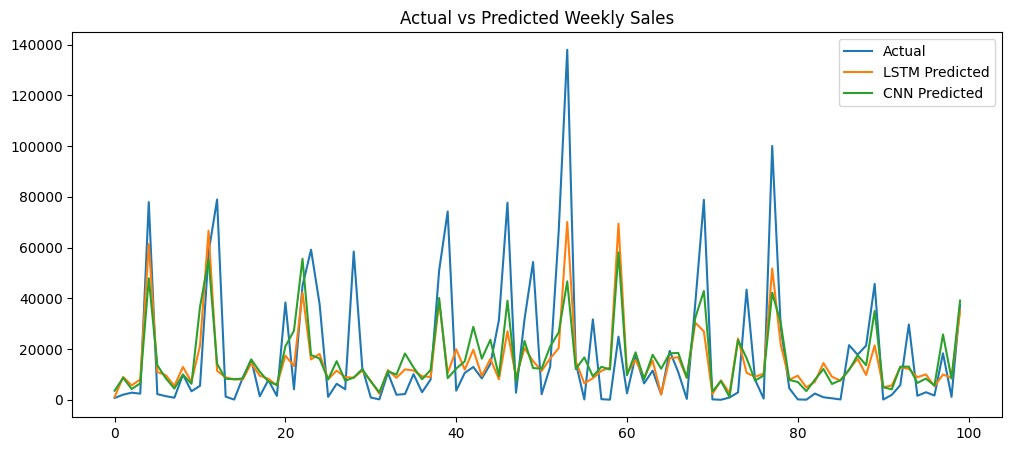

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_actual[:100], label='Actual')
plt.plot(lstm_preds_actual[:100], label='LSTM Predicted')
plt.plot(cnn_preds_actual[:100], label='CNN Predicted')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# y_test_actual, lstm_preds_actual, cnn_preds_actual should be defined as before

# Flatten arrays if needed
y_true = y_test_actual.flatten()
lstm_pred = lstm_preds_actual.flatten()
cnn_pred = cnn_preds_actual.flatten()

# LSTM Metrics
lstm_mae = mean_absolute_error(y_true, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred))
lstm_r2 = r2_score(y_true, lstm_pred)

# CNN Metrics
cnn_mae = mean_absolute_error(y_true, cnn_pred)
cnn_rmse = np.sqrt(mean_squared_error(y_true, cnn_pred))
cnn_r2 = r2_score(y_true, cnn_pred)

print(f"LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, R²: {lstm_r2:.4f}")
print(f"CNN  MAE: {cnn_mae:.2f}, RMSE: {cnn_rmse:.2f}, R²: {cnn_r2:.4f}")


LSTM MAE: 11714.33, RMSE: 19267.85, R²: 0.2804
CNN  MAE: 11739.74, RMSE: 18980.18, R²: 0.3017
